# Embeddings analysis

## Prepare dataset

Loading and preparing dataset as in [the training for Movielens/IMDB dataset](https://github.com/tinyclues/recsys-multi-atrribute-benchmark/blob/master/training/movielens%20simple%20model.ipynb).

In [1]:
DATASET = 'movielens_imdb'
TECHNICAL_COLUMNS = ['userId', 'date']
TASKS = ['imdbId', 'director', 'genre']
BATCH_SIZE_TRAIN = 10080
BATCH_SIZE_EVAL = 50400

In [2]:
from utils import load_dataset

datasets = {}
for split_name in ['train', 'val', 'test']:
    datasets[split_name] = load_dataset(DATASET, split_name)

In [3]:
from utils import AGG_PREFIX

all_columns = list(datasets['train'].element_spec.keys())
user_features = list(filter(lambda x: x.startswith(AGG_PREFIX), all_columns))
offer_features = list(filter(lambda x: x not in user_features + TECHNICAL_COLUMNS, all_columns))

In [4]:
from functools import partial
from uuid import uuid4

from utils import rebatch_by_events

datasets['train'] = rebatch_by_events(datasets['train'], batch_size=BATCH_SIZE_TRAIN, date_column='date', nb_events_by_user_by_day=8)
for key in ['val', 'test']:
    datasets[key] = rebatch_by_events(datasets[key], batch_size=BATCH_SIZE_EVAL, date_column='date', nb_events_by_user_by_day=8,
                                      seed=1729).cache(f'/tmp/{uuid4()}.tf')

In [5]:
from utils import add_equal_weights

for key in datasets:
    datasets[key] = datasets[key].map(partial(add_equal_weights, features=offer_features))

In [ ]:
from utils import load_inverse_lookups

inverse_lookups = load_inverse_lookups(DATASET)

## Prepare evaluation dataset

In [8]:
%%time
from utils import get_task_offer_features, remap_features_using_key
test_datasets, test_offer_tensors = {}, {}
for task_offer_feature in TASKS:
    test_offer_tensors[task_offer_feature] = \
        get_task_offer_features(datasets['test'], task_offer_feature, offer_features)
    test_datasets[task_offer_feature] = \
        remap_features_using_key(datasets['test'], task_offer_feature,
                                 test_offer_tensors[task_offer_feature])

CPU times: user 1min 24s, sys: 7.21 s, total: 1min 31s
Wall time: 1min 23s


## Model

In [23]:
import sys, importlib
importlib.reload(sys.modules['model_parameters'])

<module 'model_parameters' from '/home/jupyter/recsys-multi-atrribute-benchmark/training/model_parameters.py'>

In [24]:
if DATASET == 'movielens_imdb':
    from model_parameters import movielens_model as model_definition
    from model_parameters import MOVIELENS_EPOCHS as EPOCHS
elif DATASET == 'rees_ecommerce':
    from model_parameters import rees_model as model_definition
    from model_parameters import REES_EPOCHS as EPOCHS

NUMBER_OF_NEGATIVES = 4

In [25]:
import itertools

MODELS, EVAL_MODELS, EMBEDDING_MODELS = {}, {}, {}
for group_by, mask_net, bi_linear_interaction in [(True, True, True), (False, False, True)]:
    if mask_net and not group_by:
        continue
    key = group_by, mask_net, bi_linear_interaction
    name = '_'.join(map(lambda x: str(x).lower(), key))
    MODELS[key], EVAL_MODELS[key], EMBEDDING_MODELS[key] = \
        model_definition(user_features, offer_features, inverse_lookups, NUMBER_OF_NEGATIVES, name, *key)

## Train

In [26]:
for model in MODELS.values():
    model.fit(datasets['train'], epochs=EPOCHS, validation_data=datasets['val'])

Epoch 1/12


/home/jupyter/.local/lib/python3.9/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['date', 'userId'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/jupyter/.local/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/true_true_true/group_by/moments_2/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/true_true_true/group_by/moments_2/Reshape_3:0", shape=(None, 7, 100), dtype=float32), dense_shape=Tensor("gradient_tape/true_true_true/group_by/moments_2/Cast:0", shape=(3,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSli

231/231 [==============================] - 282s 1s/step - loss: 0.5304 - auc: 0.5396 - val_loss: 0.5086 - val_auc: 0.5555
Epoch 2/12
231/231 [==============================] - 217s 916ms/step - loss: 0.4983 - auc: 0.5942 - val_loss: 0.4967 - val_auc: 0.6013
Epoch 3/12
231/231 [==============================] - 216s 913ms/step - loss: 0.4940 - auc: 0.6078 - val_loss: 0.4955 - val_auc: 0.6092
Epoch 4/12
231/231 [==============================] - 212s 892ms/step - loss: 0.4921 - auc: 0.6116 - val_loss: 0.4953 - val_auc: 0.6023
Epoch 5/12
231/231 [==============================] - 298s 1s/step - loss: 0.4902 - auc: 0.6178 - val_loss: 0.4933 - val_auc: 0.6066
Epoch 6/12
231/231 [==============================] - 341s 1s/step - loss: 0.4900 - auc: 0.6153 - val_loss: 0.4926 - val_auc: 0.6064
Epoch 7/12
231/231 [==============================] - 335s 1s/step - loss: 0.4886 - auc: 0.6196 - val_loss: 0.4978 - val_auc: 0.5909
Epoch 9/12
231/231 [==============================] - 335s 1s/step - lo

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Embeddings similarities

In [27]:
model_with_augmentations = EMBEDDING_MODELS[(True, True, True)]
model_wo_augmentations = EMBEDDING_MODELS[(False, False, True)]

In [ ]:
# TODO clean code below

In [255]:
bb = next(iter(test_datasets['imdbId']))

In [263]:
vectors = model_wo_augmentations(bb[0])
names = inverse_lookups['imdbId'](bb[0]['imdbId']).values

In [264]:
uu, idx, cc = tf.unique_with_counts(names)
u_idx = tf.math.unsorted_segment_min(tf.range(tf.shape(idx)), idx, len(uu))
u_idx = tf.gather(u_idx, tf.argsort(cc)[::-1][:40])

In [265]:
flat_uu_vec = tf.linalg.normalize(vectors, axis=-1)[0]
flat_uu_vec = tf.reshape(tf.gather(flat_uu_vec, u_idx), (tf.shape(u_idx)[0], -1))
flat_uu_vec = tf.linalg.normalize(flat_uu_vec, axis=-1)[0]

In [266]:
cos_sim = tf.einsum('id,jd->ij', flat_uu_vec, flat_uu_vec)

In [267]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
uu_str = [x.decode() if x else 'OTHER' for x in tf.gather(uu, ordering).numpy()]
sim_df_wo_group = pd.DataFrame(data=tf.gather(tf.gather(cos_sim, ordering, axis=0), ordering, axis=1 ).numpy(), columns=uu_str, index=uu_str)

In [262]:
uu_str = [x.decode() if x else 'OTHER' for x in tf.gather(uu, ordering).numpy()]
sim_df = pd.DataFrame(data=tf.gather(tf.gather(cos_sim, ordering, axis=0), ordering, axis=1 ).numpy(), columns=uu_str, index=uu_str)

In [261]:
import numpy as np
from scipy.cluster import hierarchy
X = flat_uu_vec.numpy()
Z = hierarchy.ward(X)
ordering = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, X))

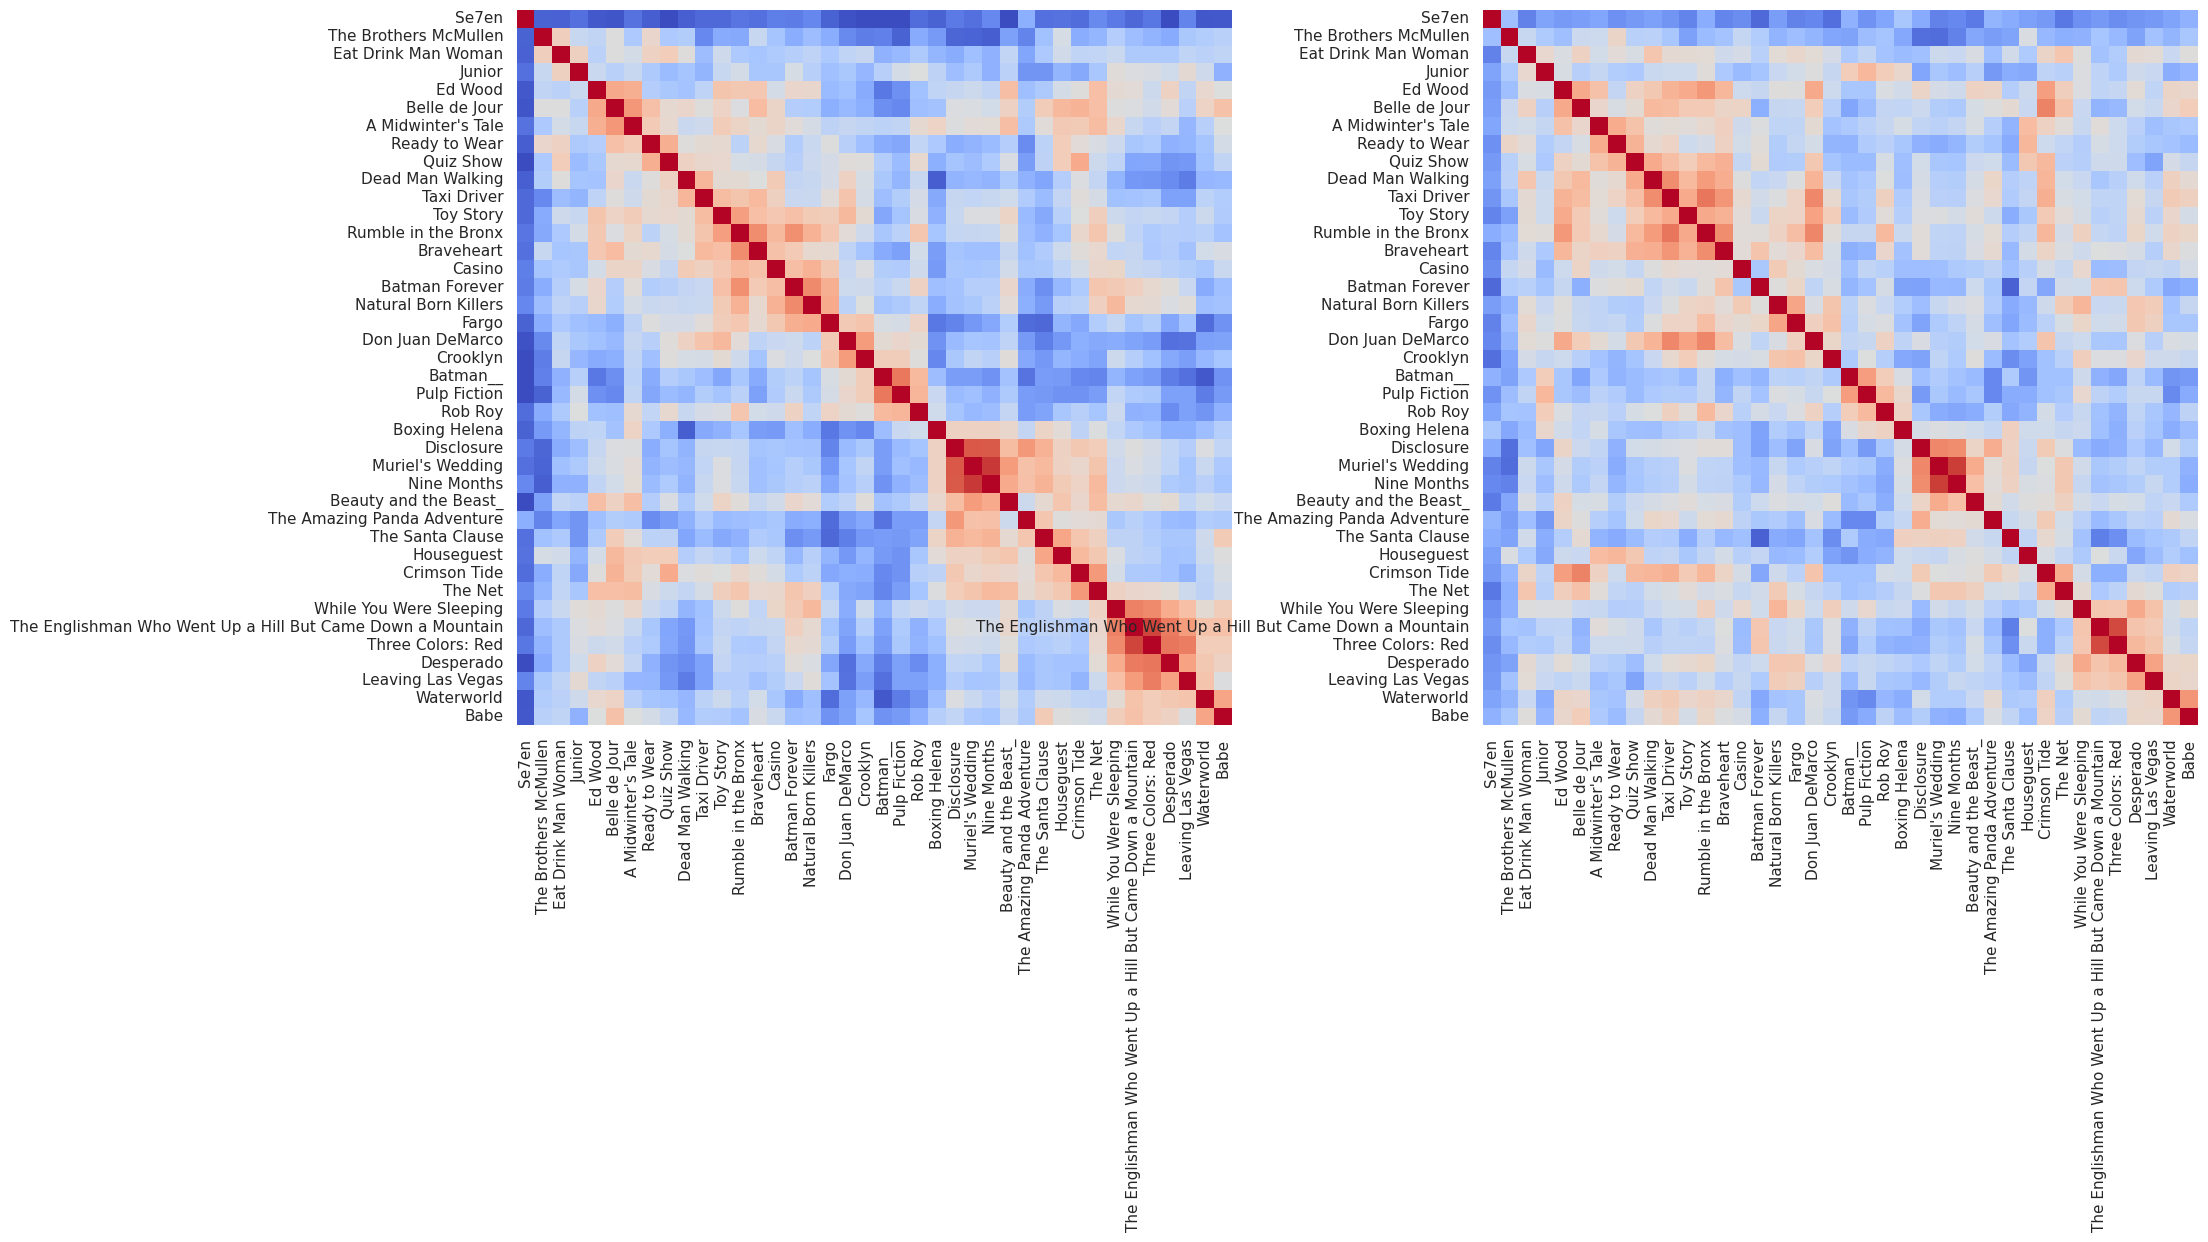

In [269]:
sns.set(rc={'figure.figsize':(21.7, 10)})

fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.35)
cmap = sns.color_palette("coolwarm", as_cmap=True, n_colors=2)
sns.heatmap(sim_df, cmap=cmap, ax=ax, cbar=False, square=True, vmin=0.05, robust=True)
sns.heatmap(sim_df_wo_group, cmap=cmap, ax=ax2, cbar=False, square=True, vmin=0.05, robust=True)
plt.show()